# 01-intro-Homework

In [5]:
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [6]:
df = pd.read_parquet("../data/yellow_tripdata_2022-01.parquet")

##### Q1: number of columns in January data

In [7]:
df.shape[1]

19

In [8]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [9]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

### Feature engineering: duration variable

In [10]:
df["duration"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
df["duration"] = df["duration"].dt.total_seconds() / 60

##### Q2:standard deviation of the trips duration in January

In [11]:
df["duration"].std()

46.44530513776802

### Dropping outliers

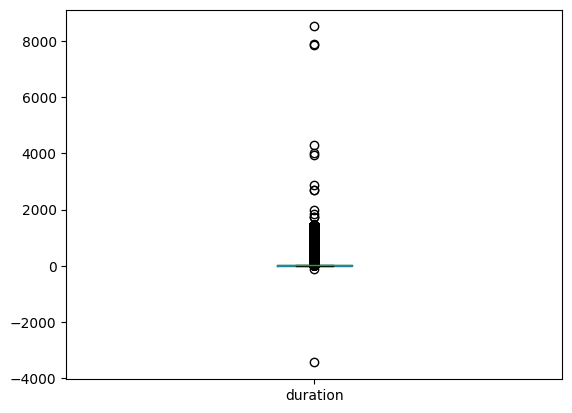

In [12]:
df.boxplot('duration', grid=False)
plt.show()

In [13]:
original_df_len = df.shape[0]

In [14]:
df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]

##### Q3: fraction of the records left after you dropped the outliers

In [15]:
df.shape[0] / original_df_len * 100

98.27547930522405

### One-hot encoding

In [16]:
df[['PULocationID', 'DOLocationID']].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [17]:
df['PULocationID'] = df['PULocationID'].astype(str)
df['DOLocationID'] = df['DOLocationID'].astype(str)

In [18]:
categorical_features = ['PULocationID', 'DOLocationID']

train_dicts = df[categorical_features].to_dict(orient="records")
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

##### Q4: dimensionality of the one-hot-encoding matrix (number of columns)

In [19]:
X_train.shape[1]

515

### Train model

In [20]:
y_train = df['duration'].values

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

### Evaluate model on train data

In [21]:
y_pred = lr.predict(X_train)

##### Q5: RMSE on train

In [22]:
mean_squared_error(y_train, y_pred, squared=False)

6.986190833327483

### Evaluate model on validation data

In [23]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    """Generate new features for the model"""
    data["duration"] = data["tpep_dropoff_datetime"] - data["tpep_pickup_datetime"]
    data["duration"] = data["duration"].dt.total_seconds() / 60 
    return data

def prepare_data(data: pd.DataFrame, features: list, target: str, dv: DictVectorizer) -> pd.DataFrame:
    """Preare features for training"""
    # Drop outliers
    data = data[(data[target] >= 1) & (data[target] <= 60)]
    # One-hot-encoding
    df[features] = df[features].astype(str)
    data_dicts = data[features].to_dict(orient="records")
    X = dv.transform(data_dicts)
    # Return X and y
    y = data[target].values
    return X, y

In [24]:
# Load validation data
val = pd.read_parquet("../data/yellow_tripdata_2022-02.parquet")

# Generate target variable
val = feature_engineering(val)

# Prepare data for training
training_features = ['PULocationID', 'DOLocationID']
X_val, y_val = prepare_data(data=val, features=training_features, target="duration", dv=dv)

# Evaluation on validation data
y_pred = lr.predict(X_val)

##### Q6: RMSE on validation data

In [25]:
mean_squared_error(y_val, y_pred, squared=False)

14.619427524713196